**Author:** [Riccardo Guidotti](http://kdd.isti.cnr.it/people/riccardo-guidotti)  
**Python version:**  3.x

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from collections import defaultdict

# Data Preparation

In [2]:
from sklearn.datasets import load_breast_cancer

frame = load_breast_cancer(as_frame=True)
df = frame['data']
X = df.values
y = np.array(frame['target'])

In [3]:
from sklearn.preprocessing import StandardScaler

In [4]:
scl = StandardScaler()
X = scl.fit_transform(X)

# Box Plot

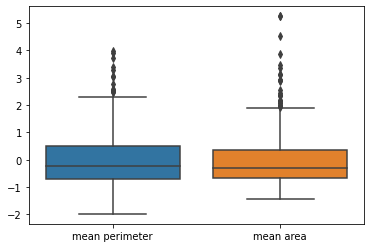

In [5]:
idx0 = 2
idx1 = 3

sns.boxplot(data=[X[:,idx0], X[:,idx1]])
plt.xticks([0,1], [frame.feature_names[idx0], frame.feature_names[idx1]])
plt.show()

# Automatic BoxPlot

In [6]:
def is_outlier(x, k=1.5):
    q1 = np.quantile(x, 0.25)
    q3 = np.quantile(x, 0.75)
    iqr = q3 - q1
    outliers = list()
    for v in x:
        if v < q1 - k * iqr or v > q3 + k * iqr:
            outliers.append(True)
        else:
            outliers.append(False)
    return np.array(outliers)

In [7]:
frame.feature_names[0]

'mean radius'

In [8]:
outliers = is_outlier(X[:,0], k=1.5)
np.unique(outliers, return_counts=True)

(array([False,  True]), array([555,  14]))

# HBOS

In [9]:
from pyod.models.hbos import HBOS

In [10]:
clf = HBOS()
clf.fit(X)

HBOS(alpha=0.1, contamination=0.1, n_bins=10, tol=0.5)

In [11]:
clf.decision_scores_

array([71.82117163, 42.74608859, 53.35105753, 60.49238623, 50.68916709,
       41.28863482, 40.64896401, 43.15000065, 43.7645633 , 52.30851172,
       32.75258853, 43.63542634, 69.83773473, 42.04003159, 50.09172783,
       50.88421203, 33.71317711, 49.9130123 , 49.70546212, 28.41977146,
       27.37484123, 34.14597911, 54.65709676, 47.65237519, 51.02954433,
       62.12435592, 46.94625884, 49.0264205 , 47.92395155, 40.0189887 ,
       54.53008093, 48.11117421, 53.37260562, 51.77765106, 45.53759479,
       44.66519177, 36.95237025, 32.4785786 , 42.71365764, 33.11683157,
       26.42770764, 38.47777017, 67.49763423, 34.40530437, 32.50954226,
       54.53056878, 34.60803006, 36.37752416, 25.31405072, 28.28229836,
       28.6944677 , 27.6496872 , 25.04922245, 47.38838802, 30.83372415,
       25.93549179, 45.56889135, 40.28349859, 29.42654885, 40.48090306,
       39.75646664, 41.44127208, 53.7918173 , 44.87525847, 39.41127944,
       37.06453106, 35.37401542, 26.81451275, 57.96231008, 25.52

In [12]:
outliers = clf.predict(X)
np.unique(outliers, return_counts=True)

(array([0, 1]), array([512,  57]))

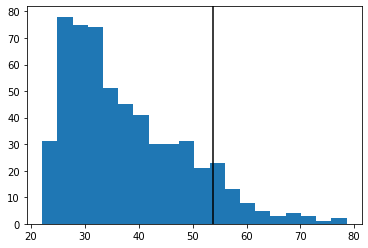

In [13]:
plt.hist(clf.decision_scores_, bins=20)
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==1)]), c='k')
plt.show()

In [14]:
clf.decision_function(X)

array([71.82117163, 42.74608859, 53.35105753, 60.49238623, 50.68916709,
       41.28863482, 40.64896401, 43.15000065, 43.7645633 , 52.30851172,
       32.75258853, 43.63542634, 69.83773473, 42.04003159, 50.09172783,
       50.88421203, 33.71317711, 49.9130123 , 49.70546212, 28.41977146,
       27.37484123, 34.14597911, 54.65709676, 47.65237519, 51.02954433,
       62.12435592, 46.94625884, 49.0264205 , 47.92395155, 40.0189887 ,
       54.53008093, 48.11117421, 53.37260562, 51.77765106, 45.53759479,
       44.66519177, 36.95237025, 32.4785786 , 42.71365764, 33.11683157,
       26.42770764, 38.47777017, 67.49763423, 34.40530437, 32.50954226,
       54.53056878, 34.60803006, 36.37752416, 25.31405072, 28.28229836,
       28.6944677 , 27.6496872 , 25.04922245, 47.38838802, 30.83372415,
       25.93549179, 45.56889135, 40.28349859, 29.42654885, 40.48090306,
       39.75646664, 41.44127208, 53.7918173 , 44.87525847, 39.41127944,
       37.06453106, 35.37401542, 26.81451275, 57.96231008, 25.52

# EllEnv

In [15]:
from sklearn.covariance import EllipticEnvelope

In [16]:
ellenv = EllipticEnvelope(random_state=0)
ellenv.fit(X)

EllipticEnvelope(random_state=0)

In [17]:
# predict returns 1 for an inlier and -1 for an outlier
outliers = ellenv.predict(X)

In [18]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([ 57, 512]))

# kNN

In [19]:
from pyod.models.knn import KNN

In [20]:
clf = KNN(n_neighbors=5)
clf.fit(X)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [21]:
outliers = clf.predict(X)
np.unique(outliers, return_counts=True)

(array([0, 1]), array([516,  53]))

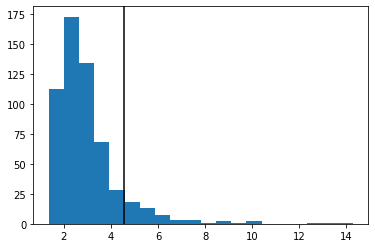

In [22]:
plt.hist(clf.decision_scores_, bins=20)
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==1)]), c='k')
plt.show()

# LOF

In [23]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [25]:
clf = LocalOutlierFactor(n_neighbors=2) # , novelty=True
clf.fit(X_train)

y_pred = clf.fit_predict(X_test)

In [26]:
np.unique(y_pred, return_counts=True)

(array([-1,  1]), array([ 18, 153]))

In [27]:
clf = LocalOutlierFactor(n_neighbors=2)
outliers = clf.fit_predict(X)
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([ 35, 534]))

negative_outlier_factor_

The opposite LOF of the training samples. The higher, the more normal. Inliers tend to have a LOF score close to 1 (negative_outlier_factor_ close to -1), while outliers tend to have a larger LOF score.

The local outlier factor (LOF) of a sample captures its supposed ‘degree of abnormality’. It is the average of the ratio of the local reachability density of a sample and those of its k-nearest neighbors.

In [28]:
clf.negative_outlier_factor_

array([-1.17088963, -1.27054811, -1.0379891 , -1.40450113, -1.3459017 ,
       -1.11102946, -0.98133324, -1.14727934, -1.16595936, -1.52830635,
       -0.99209184, -1.05930338, -1.18343086, -1.13398173, -1.18273203,
       -1.11315805, -0.99416899, -1.01644245, -1.01632367, -1.09487154,
       -0.99777014, -1.3951239 , -1.31882874, -1.02057605, -1.04123514,
       -1.16603112, -1.10622341, -1.07385542, -1.34024895, -0.99758986,
       -1.01152581, -1.1600516 , -1.04080259, -1.04609073, -1.01334539,
       -1.22689119, -1.01952048, -1.31079361, -1.71925793, -1.00687848,
       -1.10204609, -1.06262572, -1.91921259, -0.96563842, -1.03359158,
       -1.1740867 , -0.91582589, -0.95227863, -1.05432483, -1.02500953,
       -1.08960384, -1.02506489, -0.9944927 , -1.2766062 , -0.99416899,
       -1.04669104, -1.09397173, -0.95399659, -1.01904535, -1.00845916,
       -1.11447579, -1.10306155, -1.1445874 , -1.34134215, -1.05506534,
       -1.04462495, -1.17521978, -1.18012186, -1.87780824, -1.03

In [29]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([ 35, 534]))

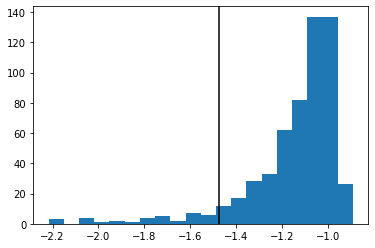

In [30]:
plt.hist(clf.negative_outlier_factor_, bins=20)
plt.axvline(np.min(clf.negative_outlier_factor_[np.where(outliers==1)]), c='k')
plt.show()

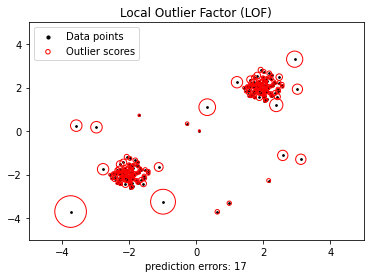

In [31]:
np.random.seed(42)

# Generate train data
X_inliers = 0.3 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers + 2, X_inliers - 2]

# Generate some outliers
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
Xa = np.r_[X_inliers, X_outliers]

n_outliers = len(X_outliers)
ground_truth = np.ones(len(Xa), dtype=int)
ground_truth[-n_outliers:] = -1

# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=3, contamination=0.01)
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit_predict(Xa)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_

plt.title("Local Outlier Factor (LOF)")
plt.scatter(Xa[:, 0], Xa[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(Xa[:, 0], Xa[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

In [32]:
from pyod.models.lof import LOF

In [33]:
clf = LOF()
clf.fit(X)

LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=20, novelty=True, p=2)

In [34]:
outliers = clf.predict(X)
np.unique(outliers, return_counts=True)

(array([0, 1]), array([519,  50]))

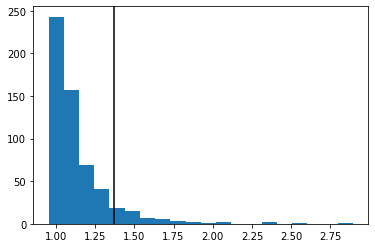

In [35]:
plt.hist(clf.decision_scores_, bins=20)
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==1)]), c='k')
plt.show()

# COF

In [36]:
from pyod.models.cof import COF

In [37]:
clf = COF()
clf.fit(X)

COF(contamination=0.1, method='fast', n_neighbors=None)

In [38]:
outliers = clf.predict(X)
np.unique(outliers, return_counts=True)

(array([0, 1]), array([512,  57]))

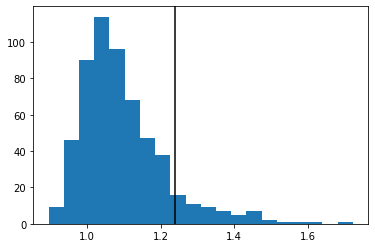

In [39]:
plt.hist(clf.decision_scores_, bins=20)
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==1)]), c='k')
plt.show()

# DBSCAN

In [40]:
from sklearn.cluster import DBSCAN

In [41]:
dbscan = DBSCAN(eps=5, min_samples=10)
dbscan.fit(X)

DBSCAN(eps=5, min_samples=10)

In [42]:
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0]), array([ 24, 545]))

In [43]:
df.loc[np.where(dbscan.labels_==-1)]

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
3,11.420,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.25750,0.6638,0.17300
9,12.460,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,...,15.090,40.68,97.65,711.4,0.18530,1.05800,1.1050,0.22100,0.4366,0.20750
12,19.170,24.80,132.40,1123.0,0.09740,0.24580,0.20650,0.11180,0.2397,0.07800,...,20.960,29.94,151.70,1332.0,0.10370,0.39030,0.3639,0.17670,0.3176,0.10230
42,19.070,24.81,128.30,1104.0,0.09081,0.21900,0.21070,0.09961,0.2310,0.06343,...,24.090,33.17,177.40,1651.0,0.12470,0.74440,0.7242,0.24930,0.4670,0.10380
68,9.029,17.33,58.79,250.5,0.10660,0.14130,0.31300,0.04375,0.2111,0.08046,...,10.310,22.65,65.50,324.7,0.14820,0.43650,1.2520,0.17500,0.4228,0.11750
71,8.888,14.64,58.79,244.0,0.09783,0.15310,0.08606,0.02872,0.1902,0.08980,...,9.733,15.67,62.56,284.4,0.12070,0.24360,0.1434,0.04786,0.2254,0.10840
78,20.180,23.97,143.70,1245.0,0.12860,0.34540,0.37540,0.16040,0.2906,0.08142,...,23.370,31.72,170.30,1623.0,0.16390,0.61640,0.7681,0.25080,0.5440,0.09964
83,19.100,26.29,129.10,1132.0,0.12150,0.17910,0.19370,0.14690,0.1634,0.07224,...,20.330,32.72,141.30,1298.0,0.13920,0.28170,0.2432,0.18410,0.2311,0.09203
108,22.270,19.67,152.80,1509.0,0.13260,0.27680,0.42640,0.18230,0.2556,0.07039,...,28.400,28.01,206.80,2360.0,0.17010,0.69970,0.9608,0.29100,0.4055,0.09789
122,24.250,20.20,166.20,1761.0,0.14470,0.28670,0.42680,0.20120,0.2655,0.06877,...,26.020,23.99,180.90,2073.0,0.16960,0.42440,0.5803,0.22480,0.3222,0.08009


# CBLOF

In [44]:
from pyod.models.cblof import CBLOF

In [45]:
clf = CBLOF()  # problem with my KMeans does not run
clf.fit(X)

CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.1, n_clusters=8, n_jobs=None, random_state=None,
   use_weights=False)

In [46]:
outliers = clf.predict(X)
np.unique(outliers, return_counts=True)

(array([0, 1]), array([512,  57]))

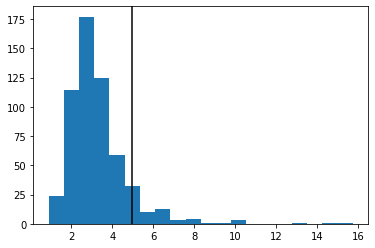

In [47]:
plt.hist(clf.decision_scores_, bins=20)
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==1)]), c='k')
plt.show()

# ABOD

In [48]:
from pyod.models.abod import ABOD

In [49]:
clf = ABOD()
clf.fit(X)

ABOD(contamination=0.1, method='fast', n_neighbors=5)

In [50]:
outliers = clf.predict(X)
np.unique(outliers, return_counts=True)

(array([0, 1]), array([507,  62]))

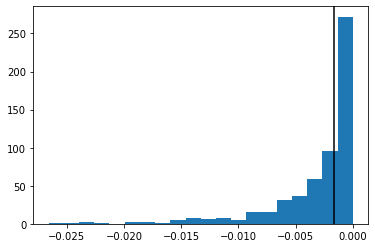

In [51]:
plt.hist(clf.decision_scores_, bins=20)
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==1)]), c='k')
plt.show()

# LODA

In [52]:
from pyod.models.loda import LODA

In [53]:
clf = LODA()
clf.fit(X)

LODA(contamination=0.1, n_bins=10, n_random_cuts=100)

In [54]:
outliers = clf.predict(X)
np.unique(outliers, return_counts=True)

(array([0, 1]), array([512,  57]))

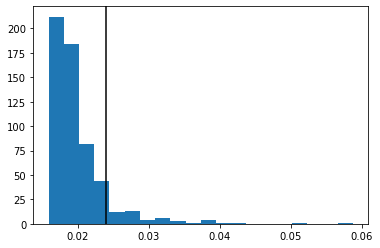

In [55]:
plt.hist(clf.decision_scores_, bins=20)
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==1)]), c='k')
plt.show()

# Isolation Forest

In [56]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [58]:
clf = IsolationForest(random_state=0)
clf.fit(X_train)

IsolationForest(random_state=0)

In [59]:
outliers = clf.predict(X_test)

In [60]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([ 17, 154]))

In [61]:
from pyod.models.iforest import IsolationForest

In [62]:
clf = IsolationForest()
clf.fit(X)

IsolationForest()

In [63]:
outliers = clf.predict(X)
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([ 56, 513]))

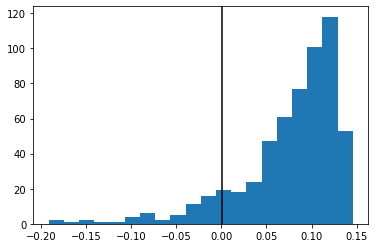

In [64]:
plt.hist(clf.decision_function(X), bins=20)
plt.axvline(np.min(clf.decision_function(X)[np.where(outliers==1)]), c='k')
plt.show()

In [65]:
# Combination: https://pyod.readthedocs.io/en/latest/example.html

# Example RkNN

In [66]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


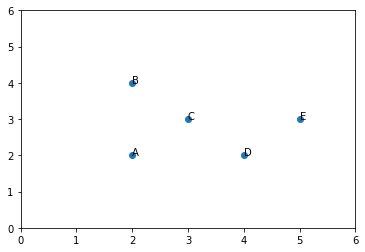

In [67]:
D = np.array([
    [2, 2],
    [2, 4],
    [3, 3],
    [4, 2],
    [5, 3],
])


plt.scatter(D[:, 0], D[:, 1])
for d, l in zip(D, ['A', 'B', 'C', 'D', 'E']):
    plt.text(d[0], d[1], l)
plt.xlim([0, 6])
plt.ylim([0, 6])
plt.show()

In [68]:
from scipy.spatial.distance import pdist, squareform

In [69]:
dist = squareform(pdist(D, 'cityblock'))
for i in range(len(dist)):
    dist[i, i] = np.inf
dist

array([[inf,  2.,  2.,  2.,  4.],
       [ 2., inf,  2.,  4.,  4.],
       [ 2.,  2., inf,  2.,  2.],
       [ 2.,  4.,  2., inf,  2.],
       [ 4.,  4.,  2.,  2., inf]])

In [70]:
k = 3
knn = np.argsort(dist, axis=1)[:, :k]
knn

array([[1, 2, 3],
       [0, 2, 3],
       [0, 1, 3],
       [0, 2, 4],
       [2, 3, 0]])

In [71]:
Rknn = np.zeros((len(dist), len(dist)))
for i in range(len(dist)):
    for j in knn[i]:
        Rknn[j][i] = 1
Rknn

array([[0., 1., 1., 1., 1.],
       [1., 0., 1., 0., 0.],
       [1., 1., 0., 1., 1.],
       [1., 1., 1., 0., 1.],
       [0., 0., 0., 1., 0.]])

In [72]:
Rknn_count = np.sum(Rknn, axis=1)
Rknn_count.reshape(-1,1)

array([[4.],
       [2.],
       [4.],
       [4.],
       [1.]])

# Grubbs Test

In [73]:
# https://pypi.org/project/outlier_utils/

In [74]:
import numpy as np
from scipy import stats

In [75]:
data = np.array([5, 15, 15, 14, 19, 17, 16, 20, 22, 8, 21, 28, 11, 9])

In [76]:
alpha = 0.95

In [77]:
n = len(data)

In [78]:
n

14

In [79]:
significance_level = alpha / (2*n)  #alpha / n

In [80]:
1-significance_level

0.9660714285714286

In [81]:
t = stats.t.isf(significance_level, n-2, 2)

In [82]:
t

4.006660107102302

In [83]:
g_test = ((n-1) / np.sqrt(n)) * (np.sqrt(t**2 / (n-2 + t**2)))

In [84]:
g_test

2.6282680955893514

In [85]:
relative_values = abs(data - data.mean())
index = relative_values.argmax()
value = relative_values[index]

In [86]:
index, value

(11, 12.285714285714286)

In [87]:
g = value / data.std()

In [88]:
g, g_test

(2.066448124728515, 2.6282680955893514)

In [89]:
if g > g_test:
    print('outlier')
else:
    print('inlier')

inlier


In [90]:
stats.t.isf(0.01, 10)

2.7637694574478893

In [91]:
stats.t.isf(0.01, 100)

2.364217365904738

In [92]:
stats.t.isf(0.01, 1000)

2.33008267475551

In [93]:
stats.t.isf(0.001, 10)

4.143700494046624

In [94]:
stats.t.isf(0.001, 10)

4.143700494046624

In [95]:
stats.t.isf(0.001, 100)

3.1737394889844106

In [96]:
stats.t.isf(0.001, 1000)

3.098402163912876

In [97]:
stats.t.isf(0.01, 100, 2)

4.364217365904738

# Likelihood Appraoch

In [98]:
import numpy as np
from scipy import stats

In [99]:
data = np.array([100, 5, 14, 15, 15, 14, 19, 17, 16, 20, 22, 8, 21, 28, 11, 9, 50])

In [100]:
def norm_dist(x, mu, sigma):
    return 1/(np.sqrt(2*np.pi)*sigma) * np.e**(-((x-mu)**2)/(2*sigma**2))
              
def unif_dist(x, n):
    return 1/n

In [101]:
M = np.copy(data)
A = list()
muM = np.mean(M)
sigmaM = np.std(M)

In [102]:
norm_dist(15, muM, sigmaM)

0.017323544875621277

In [103]:
M = np.copy(data)
A = []
lambda_par = 0.3

muM = np.mean(M)
sigmaM = np.std(M)
sizeA = len(A)

sumM = np.sum([norm_dist(x, muM, sigmaM) for x in M])

sumA = np.sum([unif_dist(x, sizeA) for x in A])

ll = (len(M) * np.log(1-lambda_par) + sumM + len(A) * np.log(lambda_par) + sumA)

In [104]:
M = np.copy(data)
A = []
c = 0.2
for i, x in enumerate(data):
    A.append(x)
    M = np.array([xo for j, xo in enumerate(data) if i!=j])
    muM = np.mean(M)
    sigmaM = np.std(M)
    sizeA = len(A)
    sumM = np.sum([norm_dist(x, muM, sigmaM) for x in M])
    sumA = np.sum([unif_dist(x, sizeA) for x in A])
    ll_xi = (len(M) * np.log(1-lambda_par) + sumM + len(A) * np.log(lambda_par) + sumA)
    delta_ll = abs(ll - ll_xi)
    print(i, delta_ll, 'outlier' if delta_ll > c else 'inlier')
    M = np.copy(data)
    A = list()

0 0.3977128481343115 outlier
1 0.13457765542953126 inlier
2 0.12934931124330795 inlier
3 0.1290276899776579 inlier
4 0.1290276899776579 inlier
5 0.12934931124330795 inlier
6 0.12833240056265893 inlier
7 0.1285594628732225 inlier
8 0.12876398097943031 inlier
9 0.12831168680625638 inlier
10 0.12845932478202648 inlier
11 0.13240735661756986 inlier
12 0.12835381788710265 inlier
13 0.13043326305691316 inlier
14 0.13064686254892344 inlier
15 0.13177222116900822 inlier
16 0.15497943889092447 inlier


In [105]:
A

[]

# Deviation Based

In [106]:
data = np.array([100, 5, 14, 15, 14, 19, 17, 16, 20, 22, 8, 21, 28, 11, 9, 50])

In [107]:
def sf(x, X):
    idx = list(X).index(x)
    X1 = np.array([x1 for i, x1 in enumerate(X) if i != idx])
    return np.abs(np.var(X) - np.var(X1))

In [108]:
for i, x in enumerate(data):
    print(i, sf(x, data))

0 387.96303819444444
1 9.770295138888969
2 27.130295138888755
3 28.348072916666638
4 27.130295138888755
5 31.79696180555561
6 30.35696180555567
7 29.423628472222276
8 32.30362847222216
9 32.89029513888886
10 16.836961805555575
11 32.66807291666669
12 31.236961805555552
13 22.623628472222208
14 18.908072916666697
15 18.62970486111118


In [109]:
np.var(data)

494.55859375